In [1]:
# sys packages
import os
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append('../src')

# data manipulation
import pandas as pd
import numpy as np
import imblearn

# sckit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn import tree



from optbinning import OptimalBinning, OptimalPWBinning

# Viz packages
import matplotlib.pyplot as plt
import seaborn as sns

import utils

%matplotlib inline


In [2]:
# MACRO VARIABLES

INPUT_DIR = '../inputs/'

INPUT_DATA = 'dados.csv'

# Out of time length in days
OFT_LEN = 7

# Train Test Size

TRAIN_TEST_LEN = 0.3

# RANDOM STATE
SEED = 395

YNAME = 'fraude'

#### Import Data

In [3]:
original_df = pd.read_csv(os.path.join(INPUT_DIR, INPUT_DATA), decimal='.')
original_df.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,fecha,monto,score,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


#### Train, Test and Out-Of-Time samples

In [4]:
# It seems that 'fecha' is the date that the operation occured, so I'll use it to create a out-of-time sample
# First it needed to be converted to a date format
df = original_df.copy()

df['oper_date'] = pd.to_datetime(df['fecha'])

# Year-Month
df['oper_YM'] = df['oper_date'].apply(lambda x: x.year * 100 + x.month )

# Year-Month-Day
df['oper_YMD'] = df['oper_date'].apply(lambda x: (x.year * 100 + x.month)*100 + x.day  )


In [5]:
check_YM_dist = df.groupby('oper_YM').agg(qt=('fecha', len))
check_YM_dist

# The data has only a sample of 2 months, so its not gonna be a good choice to split a out-of time sample based on month 

,qt
oper_YM,
202003,76961
202004,73039


<AxesSubplot:xlabel='oper_YMD'>

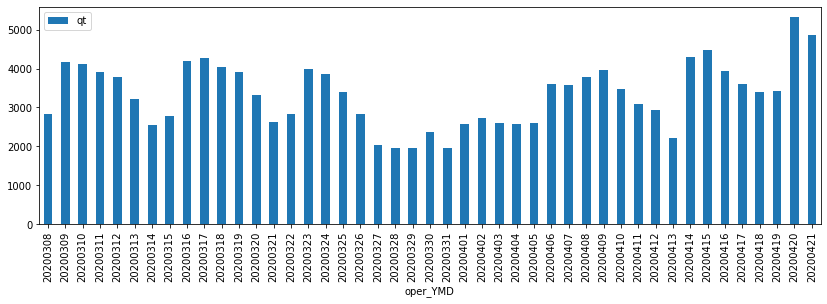

In [6]:
check_YMD_dist = df.groupby('oper_YMD').agg(qt=('fecha', len))
check_YMD_dist.plot(kind='bar', figsize=(14,4))

# The out-of-sample will be of 7 days(1 week), it ill be set on macro variables cell.

In [7]:
# Split out of time sample

__OutOfTimeMax__ = df['oper_date'].max()
__OutOfTimeMin__ = __OutOfTimeMax__ + pd.offsets.DateOffset(days=-OFT_LEN)

# This is the dataset tha will be used to evaluate the model
outoftime = df.loc[df['oper_date'] >= __OutOfTimeMin__, :]

In [8]:
# Create y and X

traintest = df.loc[df['oper_date'] < __OutOfTimeMin__, :]

y =  traintest[YNAME]

__colstodrop__ = ['fecha', 'monto', 'score', 'fraude', 'oper_date', 'oper_YM', 'oper_YMD']
X = traintest.drop(columns=__colstodrop__)


In [9]:
# Split in train test samples

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TRAIN_TEST_LEN, random_state=SEED)

#### Univariate Analysis

It's commom to observe imbalanced dataset for fraud detection problems.
If it's not handle properly it could result in a misleading model, where the accuracy is high because is more likely that the model will classify all events as a non-fraud.
In a model lije that will be a great amount of losses.

In [10]:
print('fraud_rate {:.3%}'.format(y_train.sum() / len(y_train)))

# With this rate I've opted for oversampling

# Initialize a object for oversampling with default distribution  of minority class
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority', random_state=SEED)

# Fit Oversample
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

print(' New fraud_rate {:.3%}'.format(y_train_OS.sum() / len(y_train_OS)))

fraud_rate 5.145%
 New fraud_rate 50.000%


#### Handle Missing

<AxesSubplot:>

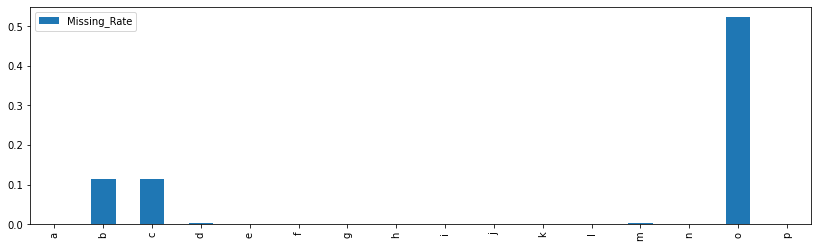

In [11]:
# Handle Missing Data
missing_freq = pd.DataFrame(X_train_OS.isna().sum() / X_train_OS.isna().count(), columns='Missing_Rate'.split())
missing_freq.plot(kind='bar', figsize=(14,4))

# Missing data will be replaced by a different category in each variable
# I haven't chosen to replace misssing by the mean/meadian of the variable, because in most cases, creating another category for the missing date has more 4explaining power.
# Column 'o' has more than 50% of its observation missing, maybe its a good choice to remove from the model

In [12]:
# replace missing data with -999 category
X_train_OS = utils.replace_missing(X_train_OS)
X_train_OS.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
0,4,0.7619,88723.38,2.0,0.161483,1.0,BR,16,Trava Tranca Eletrica Tampa Caçamba L200 Trito...,cat_d05132a,0.582140,643.0,191.0,0,-999,N
1,3,0.6320,2265.07,31.0,0.056948,14.0,AR,4,Mesa Comedor De Mármol Moderna De Diseño - Car...,cat_af842b7,0.023867,4871.0,134.0,1,-999,Y
2,4,0.8255,1272.96,29.0,0.000000,12.0,BR,22,Trocador Lençol Absorvente Descartável Mili L...,cat_0722d79,0.473002,4882.0,37.0,1,-999,N
3,4,0.6513,24235.66,42.0,0.000000,1.0,BR,2,Tela Touch Frontal Display J4 Plus J4 Core J6 ...,cat_237e2d0,0.879633,409.0,142.0,1,N,Y
4,4,0.7636,78081.00,6.0,0.000000,0.0,BR,4,Kit Retrovisor Automotivo Lcd E Câmera De Ré C...,cat_f597e16,0.518003,29.0,15.0,0,-999,N


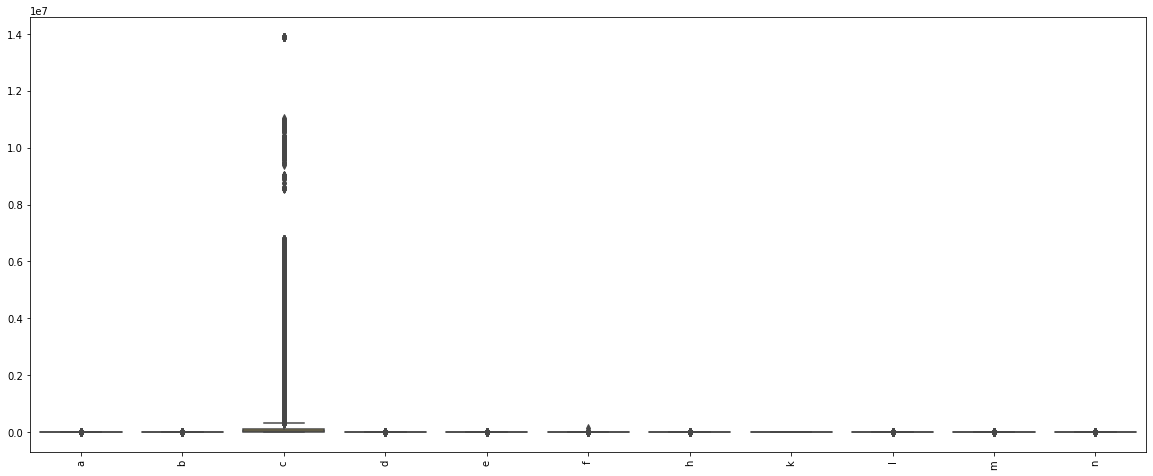

In [13]:
# Boxplot for numerical columns
fig, ax = plt.subplots(figsize=(20,8))
boxplot = sns.boxplot(data=X_train_OS)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

plt.show()

# columns 'c' has a lot of outliers 
# I will test some categorization for numeric data to get a better performance of the model and avoid noise, but maybe its a good choice to remove columns 'c' from de model.

----------------------------------------
g



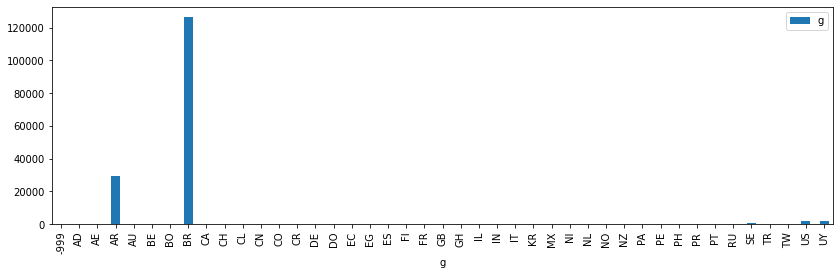

----------------------------------------
i

i has more than 20 categories and will not be ploted
----------------------------------------
j

j has more than 20 categories and will not be ploted
----------------------------------------
o



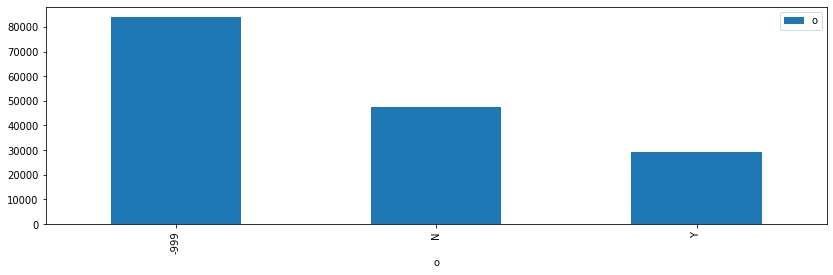

----------------------------------------
p



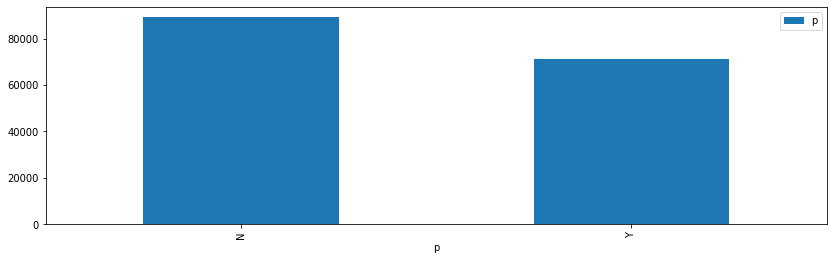

In [14]:
for col in X_train_OS.columns:
    if X_train_OS[col].dtype == 'O':
        
        print('-'*40)
        print(col)
        print()
        
        __QtdCat__ = len(X_train_OS[col].unique())

        if __QtdCat__ <= 50:

            gpd = X_train_OS.groupby(col).agg({col:'count'})
            plot_gpd = gpd.plot(kind='bar', figsize=(14,4))
            plt.show()

        else:
            print(col, 'has more than 20 categories and will not be ploted')

    else:
       pass

# Column 'g' is heavy concentrated in BR and AR so in futher analysis maybe i will split then in subgroups
# Column 'o' have a lot of missings
# Columns 'i' and 'j' are too granular, i have to bin then


In [15]:
# Correlation
correlation = pd.concat([y_train_OS, X_train_OS], axis=1)
corr = correlation.corr()
corr.sort_values(YNAME, ascending=False, inplace=True)
corr.style.background_gradient(cmap='coolwarm')

# Based on correlation matrix we have just 2 pairs of medium correlated variables (m,d) and (n,l)
# There aren't good correlation beteween X and y

,fraude,a,b,c,d,e,f,h,k,l,m,n
fraude,1.000000,-0.117349,-0.030755,0.063785,-0.072295,-0.006403,-0.034285,-0.091508,0.010487,-0.263351,-0.233089,-0.290606
c,0.063785,-0.204357,0.109592,1.000000,-0.003958,-0.011555,-0.003239,0.004317,0.000518,-0.026890,-0.013563,-0.023555
k,0.010487,0.003531,-0.006319,0.000518,0.007866,-0.002325,-0.000429,0.001638,1.000000,-0.008494,0.001477,-0.005930
e,-0.006403,0.015648,0.005501,-0.011555,-0.000525,1.000000,0.014827,0.005668,-0.002325,-0.005913,-0.002135,-0.002120
b,-0.030755,0.075551,1.000000,0.109592,0.026648,0.005501,-0.000340,0.028342,-0.006319,-0.010566,0.014378,-0.001223
f,-0.034285,0.000747,-0.000340,-0.003239,0.007401,0.014827,1.000000,0.002552,-0.000429,0.080381,0.036558,0.034903
d,-0.072295,0.017399,0.026648,-0.003958,1.000000,-0.000525,0.007401,0.008950,0.007866,0.029229,0.414007,0.075074
h,-0.091508,0.109983,0.028342,0.004317,0.008950,0.005668,0.002552,1.000000,0.001638,-0.012716,0.045698,0.023765
a,-0.117349,1.000000,0.075551,-0.204357,0.017399,0.015648,0.000747,0.109983,0.003531,-0.003078,0.055650,0.031012
m,-0.233089,0.055650,0.014378,-0.013563,0.414007,-0.002135,0.036558,0.045698,0.001477,0.229426,1.000000,0.281714


I will have some insight of the data

* First i will do a feature selection with gradient boosting to know what variables are more important (with the raw variables)
* Second i will bin the variables and get a ordered relationship with the response variable
* Then I will do a final feature selection

In [16]:
# Raw Feature Selection with Gboosting

# Label encoder for cat columns

label_encoder = LabelEncoder()

X_train_OS_LE = X_train_OS.copy()
for col in X_train_OS_LE.columns:
    X_train_OS_LE[col] = label_encoder.fit_transform(X_train_OS_LE[col])

X_train_OS_LE.head()


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
0,3,4691,48716,3,8104,6,7,16,71604,5799,49796,644,192,0,0,0
1,2,3392,8239,32,1737,19,3,4,48761,4894,2055,4872,135,1,0,1
2,3,5327,5875,30,0,17,7,22,71827,196,40477,4883,38,1,0,0
3,3,3585,28884,43,0,6,7,2,69645,1002,74767,410,143,1,1,1
4,3,4708,46500,7,0,5,7,4,42995,6802,44333,30,16,0,0,0


In [17]:
gboosting = GradientBoostingClassifier(random_state=SEED).fit(X_train_OS_LE, y_train_OS)

In [18]:
# Feature Importance

fi = pd.DataFrame({'Columns': X_train_OS_LE.columns, 
                   'Feature_importance': gboosting.feature_importances_})
#sort values
fi.sort_values('Feature_importance', ascending=False, inplace=True)

__corr__ = corr[[YNAME]].reset_index()

fi = fi.merge(__corr__, how='left', left_on=['Columns'], right_on=['index'])
fi.drop(columns=['index'], inplace=True)

fi

# Variable 'o' has a higher feature importante 
# Other columns are not so good

,Columns,Feature_importance,fraude
0,o,0.602374,NaN
1,n,0.067573,-0.290606
2,f,0.065940,-0.034285
3,m,0.062601,-0.233089
4,l,0.058326,-0.263351
5,b,0.024129,-0.030755
6,h,0.019082,-0.091508
7,c,0.018888,0.063785
8,g,0.018604,NaN
9,a,0.014721,-0.117349


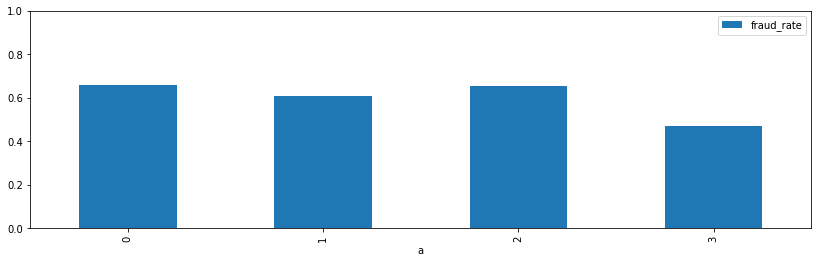

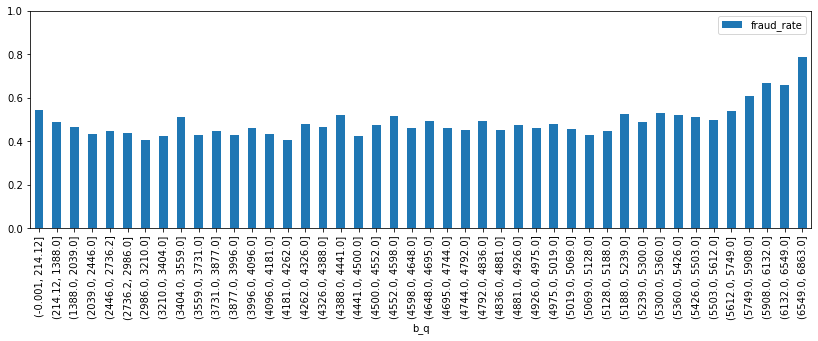

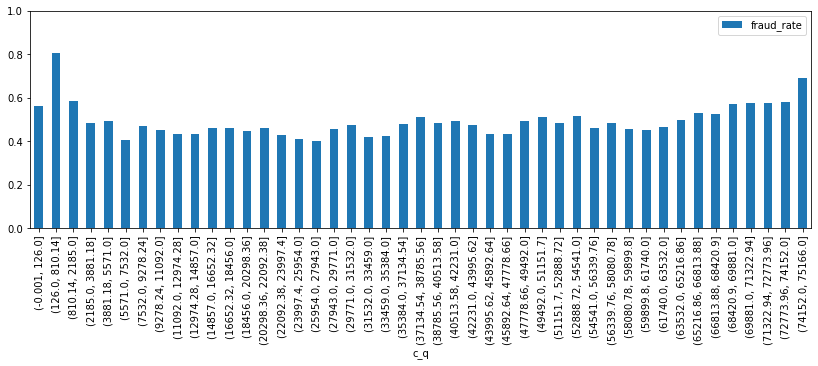

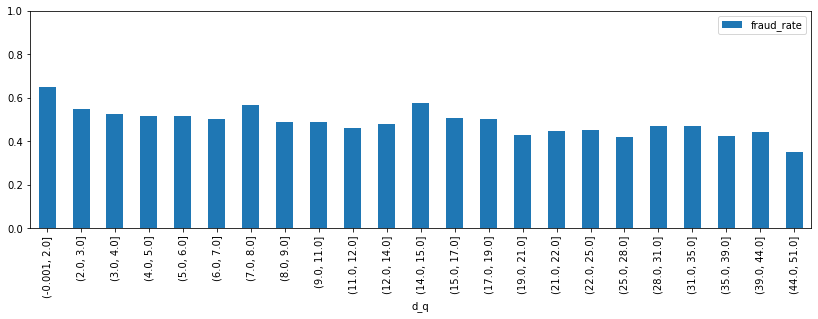

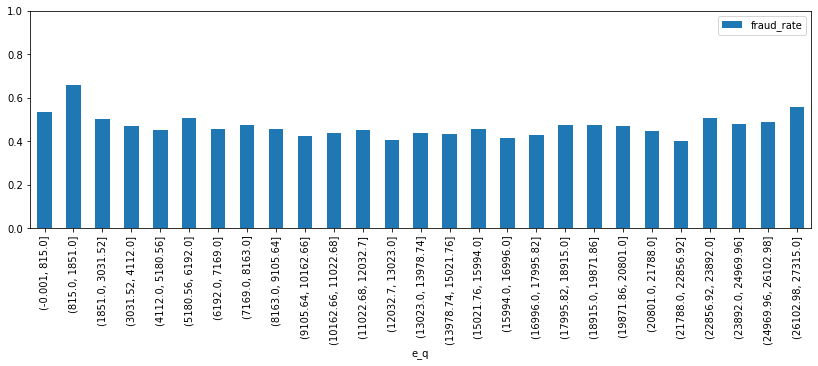

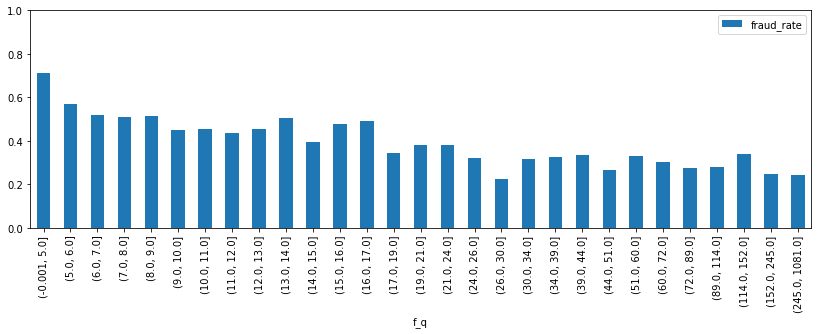

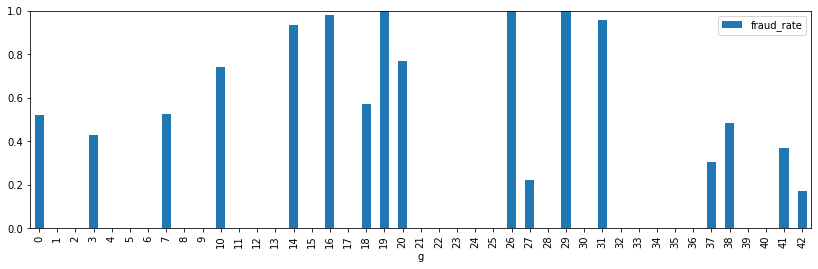

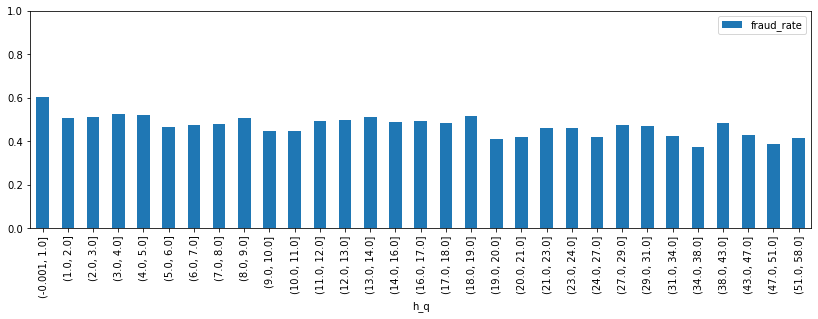

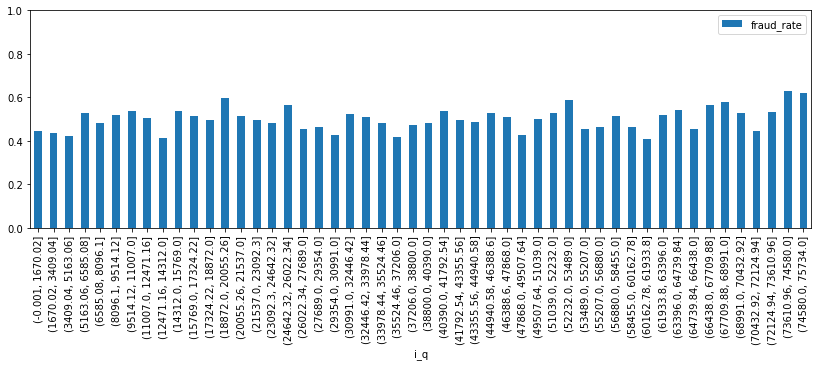

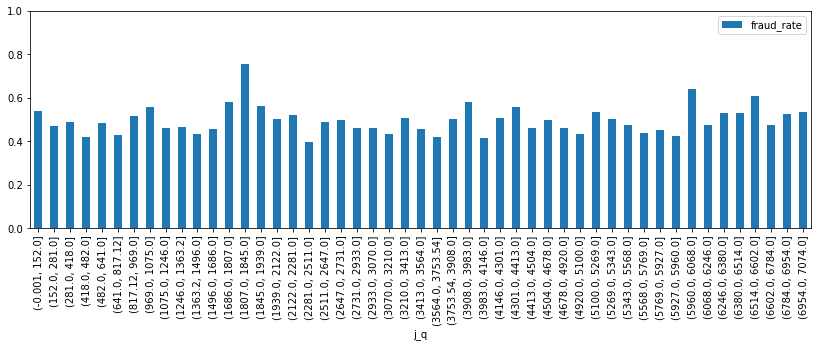

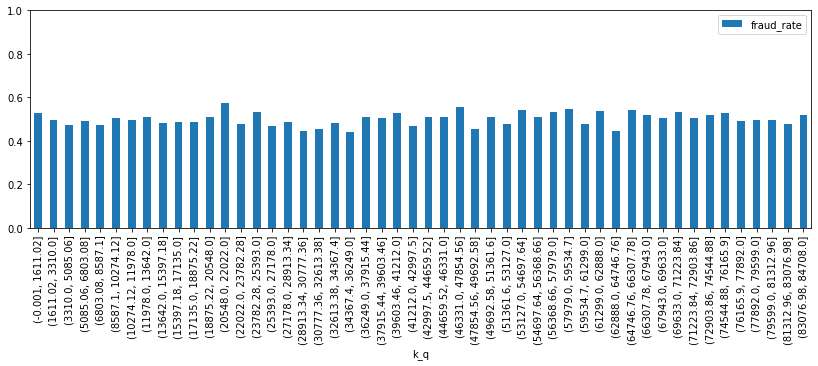

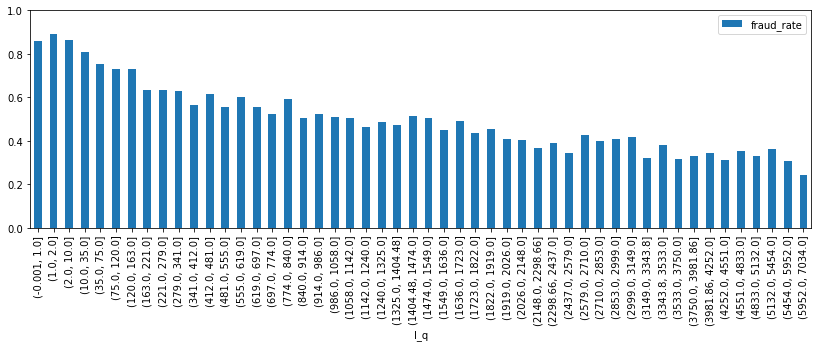

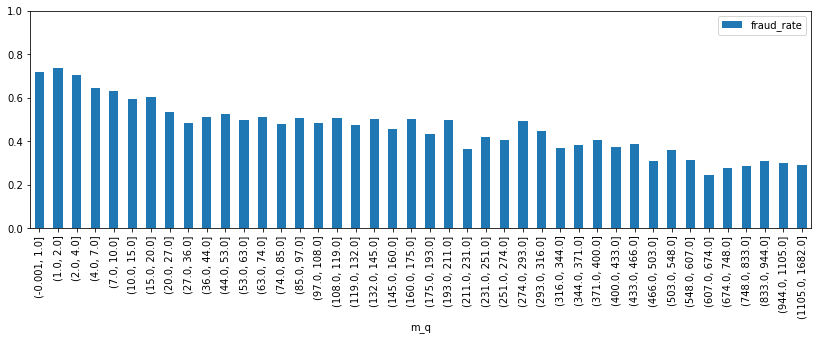

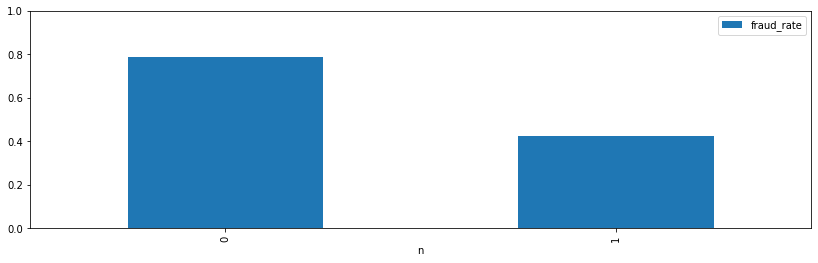

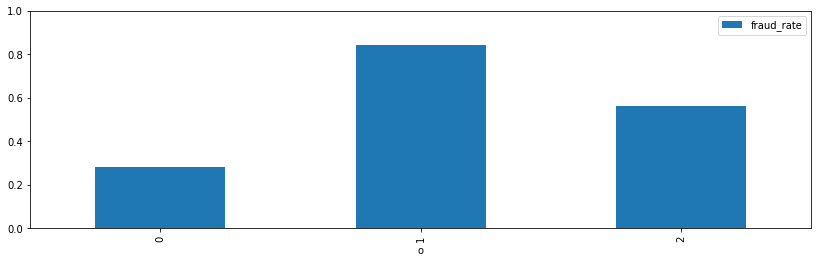

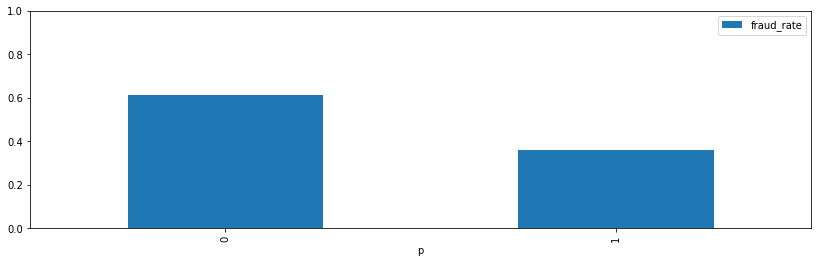

In [19]:
# bin variables

# Simple Aproach

for col in X_train_OS_LE:

    __QtdCat__ = len(X_train_OS_LE[col].unique())
    __BinDf__ = pd.concat([X_train_OS_LE[[col]], y_train_OS], axis=1)

    if __QtdCat__ > 50:
        
        __BinDf__[col + '_q'] = pd.qcut(__BinDf__[col], q=50, duplicates='drop')

        col = col + '_q'

    __BinDfGrouped__ = __BinDf__.groupby(col).agg(bad=(YNAME, 'sum'), 
                                                total=(YNAME, 'count')                                                   
                                                )

    __BinDfGrouped__['fraud_rate'] = __BinDfGrouped__['bad']/__BinDfGrouped__['total']      

    binplot = __BinDfGrouped__.plot(kind='bar', y='fraud_rate', figsize=(14,4), ylim=(0,1))

    plt.show()




        

OPTIMAL


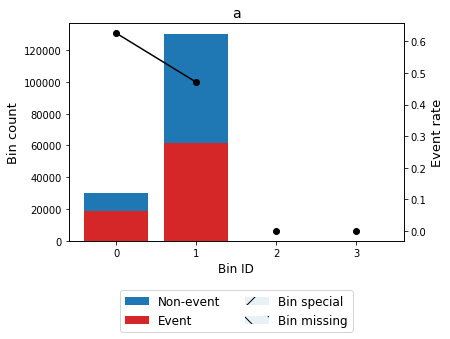

OPTIMAL


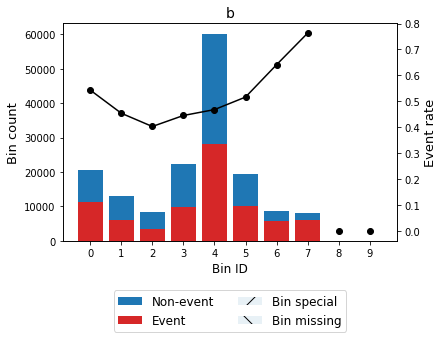

OPTIMAL


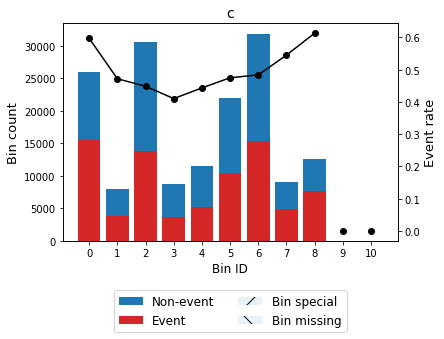

OPTIMAL


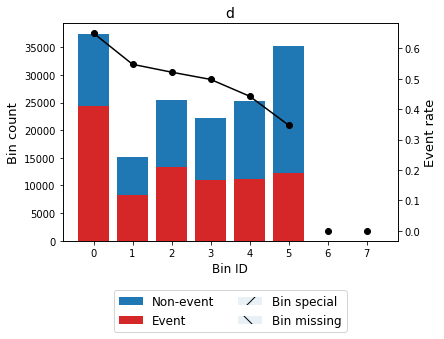

OPTIMAL


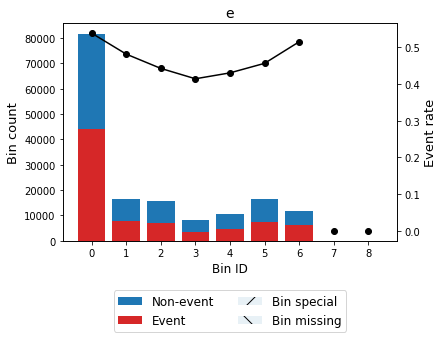

OPTIMAL


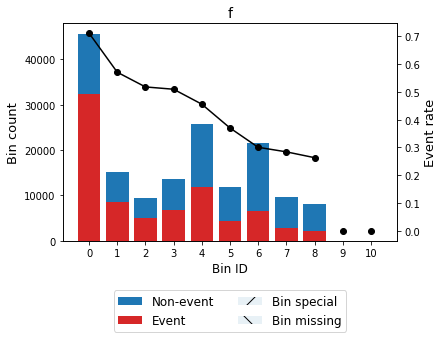

OPTIMAL


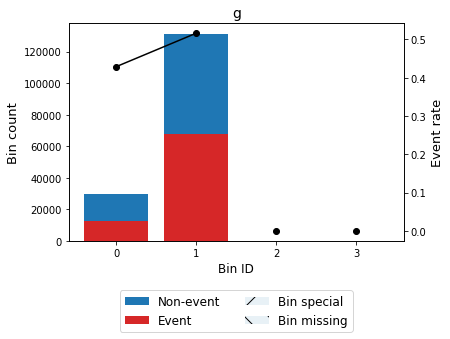

OPTIMAL


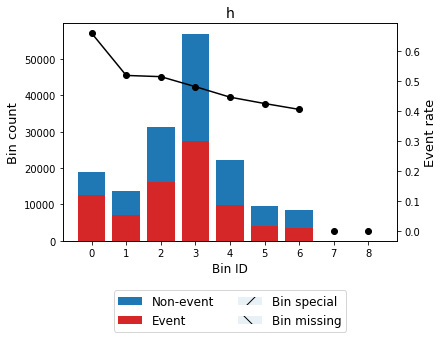

OPTIMAL


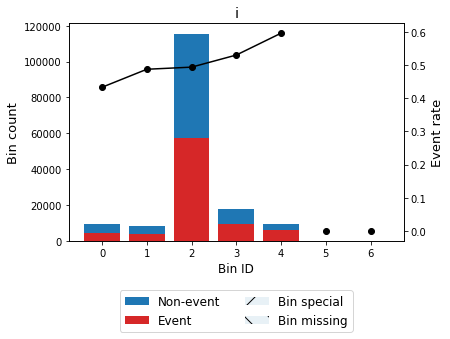

OPTIMAL


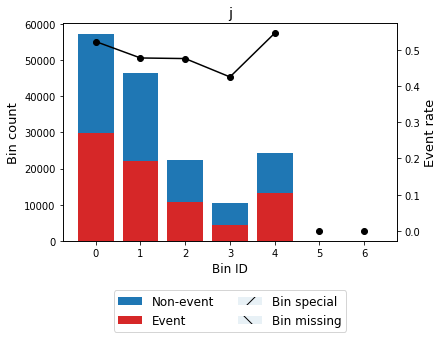

OPTIMAL


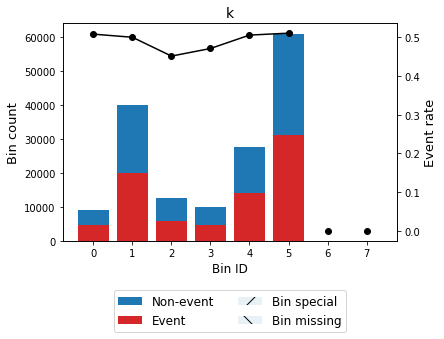

OPTIMAL


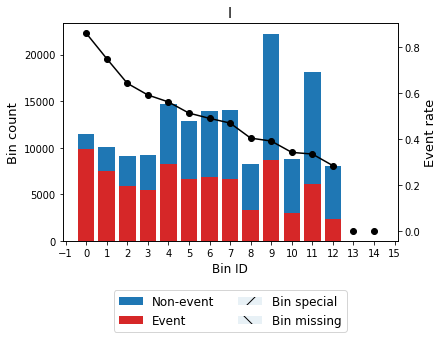

OPTIMAL


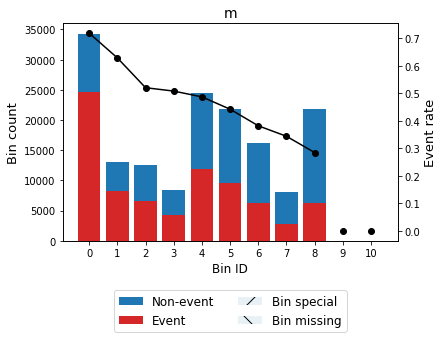

OPTIMAL


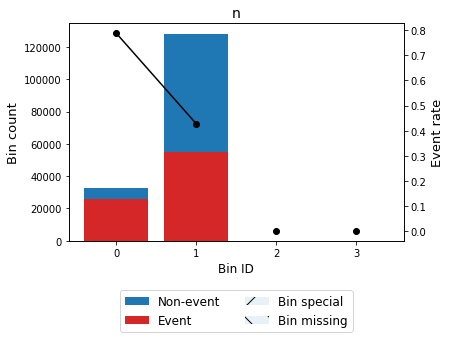

OPTIMAL


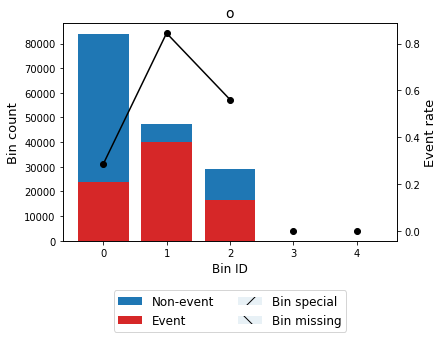

OPTIMAL


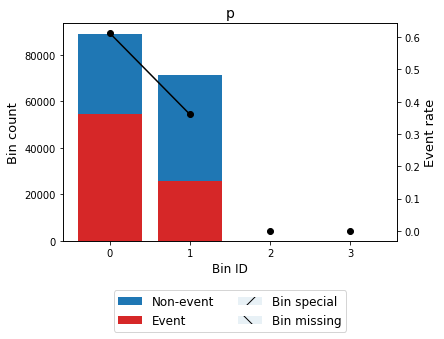

In [20]:
# using optbinning package

X_train_OS_LE_BIN = X_train_OS_LE.copy()
for col in X_train_OS_LE:

    __OpBin__ = OptimalBinning(name=col, solver="cp",)

    __OpBin__.fit(X_train_OS_LE[col], y_train_OS)

    print(__OpBin__.status)

    __OpBinRes__ = __OpBin__.binning_table

    __OpBinTable__ = __OpBinRes__.build()

    __OpBinPlot__ = __OpBinRes__.plot(metric="event_rate")

    
    X_train_OS_LE_BIN[col] = __OpBin__.transform(X_train_OS_LE[col], metric="indices")

    plt.show()

In [21]:
# Correlation
correlation = pd.concat([y_train_OS, X_train_OS_LE_BIN], axis=1)
corr = correlation.corr()
corr.sort_values(YNAME, ascending=False, inplace=True)
corr.style.background_gradient(cmap='coolwarm')


,fraude,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
fraude,1.000000,-0.121682,0.067548,-0.000561,-0.207474,-0.056920,-0.314491,0.067585,-0.122191,0.058822,-0.000628,0.012756,-0.302203,-0.285671,-0.290606,0.323001,-0.250061
o,0.323001,-0.005612,0.019790,0.006778,-0.000988,-0.004688,-0.008962,0.018945,-0.018031,-0.004373,-0.003394,0.003851,-0.017989,-0.008875,0.034761,1.000000,0.026865
g,0.067585,0.081253,0.364599,-0.046747,-0.008201,0.099259,-0.080800,1.000000,-0.056664,-0.034005,-0.016008,0.003605,-0.055636,-0.054163,-0.022173,0.018945,-0.049888
b,0.067548,0.009610,1.000000,0.353228,-0.032527,-0.059945,-0.042884,0.364599,-0.096973,0.008908,-0.032533,-0.010081,-0.008748,-0.048374,-0.005087,0.019790,-0.036932
i,0.058822,-0.025157,0.008908,0.032028,-0.019949,-0.066079,-0.035165,-0.034005,-0.027326,1.000000,-0.037632,-0.012918,-0.024984,-0.025059,-0.034655,-0.004373,-0.029352
k,0.012756,0.003831,-0.010081,0.001316,0.005185,0.001061,-0.017852,0.003605,-0.005156,-0.012918,-0.001109,1.000000,-0.005357,0.004614,-0.007144,0.003851,0.011261
c,-0.000561,0.151028,0.353228,1.000000,0.028658,-0.034711,-0.060973,-0.046747,0.260364,0.032028,-0.050967,0.001316,-0.039789,0.026221,-0.018737,0.006778,0.013900
j,-0.000628,-0.046155,-0.032533,-0.050967,0.001752,0.000097,-0.009838,-0.016008,0.020379,-0.037632,1.000000,-0.001109,-0.020624,0.004306,-0.006945,-0.003394,0.005433
e,-0.056920,0.261909,-0.059945,-0.034711,0.039205,1.000000,-0.067240,0.099259,0.150008,-0.066079,0.000097,0.001061,-0.049480,0.028206,-0.023582,-0.004688,0.002246
a,-0.121682,1.000000,0.009610,0.151028,0.097505,0.261909,-0.037060,0.081253,0.194352,-0.025157,-0.046155,0.003831,-0.001521,0.103681,0.023763,-0.005612,0.087171


In [22]:
# drop feature  with more than 0.7 correlation
CORR_TRESHOLD = 0.7
correlated_drop = list()

__corr__ = corr.drop(columns=['fraude']).drop('fraude')

for col in __corr__:
    
    __CorrCol__ = __corr__[[col]]
    __correlated__ = __CorrCol__[(__CorrCol__[col] >= CORR_TRESHOLD) & (__CorrCol__[col] < 1)]

    __CorrList__ = __correlated__.index.to_list()

    if __CorrList__:
        __CorrY__ = corr[[YNAME]]

        __CorrY__ = __CorrY__.loc[__CorrList__ + [col],:].abs()

        __ColToDrop__ = [__CorrY__.loc[__CorrY__[YNAME] == __CorrY__[YNAME].min()].index[0]]

        correlated_drop = correlated_drop + __ColToDrop__


correlated_drop = list(set(correlated_drop))

print(f'The Columns {correlated_drop} will be delated because of high correlation with other features')



The Columns ['p', 'd'] will be delated because of high correlation with other features


In [23]:
X_train_Final = X_train_OS_LE_BIN.drop(columns=correlated_drop)

X_train_Final.head()

,a,b,c,e,f,g,h,i,j,k,l,m,n,o
0,1,4,6,2,1,1,3,3,3,4,4,5,0,0
1,0,2,2,0,5,0,2,2,2,0,11,4,1,0
2,1,5,1,0,4,1,4,3,0,4,11,2,1,0
3,1,3,3,0,1,1,2,3,0,5,3,4,1,1
4,1,4,5,0,0,1,2,2,4,4,1,1,0,0


#### Train Models

In [24]:
NamesEstimators = [
    'svc',
    'lr',
    # 'dtc',
    # 'gbc',
    # 'rfc'
]

estimators = [
    LinearSVC(random_state=SEED),
    LogisticRegression(random_state=SEED),
    #  DecisionTreeClassifier(random_state=SEED),
    #  GradientBoostingClassifier(random_state=SEED),  
    #  RandomForestClassifier(random_state=SEED),
]

GridParams = [
     {'C': np.logspace(-3,3,3), 'kernel': ['linear', 'rbf']}, 
     {'C': np.logspace(-3,3,3), 'penalty':['l1','l2','elasticnet'], 'fit_intercept': [True, False] }

             ]

In [26]:
for NameClf, clf, params in zip(NamesEstimators, estimators, GridParams):

    print(NameClf)

    GS = GridSearchCV(clf, param_grid=params, n_jobs=-1, cv=7, verbose=4, scoring='roc_auc')

    clf_best = GS.fit(X_train_Final, y_train_OS)

    print(cross_val_score(clf_best, X_train_Final, y_train_OS, cv=7, scoring='roc_auc'))
    # score = clf_best.score(X_test, y_test)
    # print("{} score: {}".format(name, score))

svc
Fitting 7 folds for each of 14 candidates, totalling 98 fits
